In [1]:
#dataframes
import pandas as pd
import h5py

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

import networkx as nx
import community.community_louvain as community_louvain # pip install community

#misc
import cairosvg
import time
np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
# matplotlib.rcParams['font.family'] = [ 'sans-serif']
FS=7
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [2]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')

In [3]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

def compute_r_dot_theta_dot(args):
    xsrc, ysrc, gps_linear_x, gps_linear_y = args
    # Convert from Cartesian to Polar
    r = math.sqrt(xsrc**2 + ysrc**2)
    theta = wrapped_angular_diff(ysrc, xsrc)
    
    # Calculate r_dot and theta_dot
    r_dot = gps_linear_x * math.cos(theta) + gps_linear_y * math.sin(theta)
    theta_dot = (gps_linear_y * math.cos(theta) - gps_linear_x * math.sin(theta)) / r

    return r, theta, r_dot, theta_dot

# Prepare the data for the compute_r_dot_theta_dot function
data = list(zip(df1['xsrc'], df1['ysrc'], df1['gps_linear_x'], df1['gps_linear_y']))

# Create a multiprocessing Pool and map the function to the data
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(compute_r_dot_theta_dot, data)

# Convert the results to a DataFrame
result = pd.DataFrame(results, columns=['r', 'theta', 'r_dot', 'theta_dot'])

result['time'] = df1.time

r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])
dt=result.time[1]-result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)[:len(result['r_dot'])//2]
r_dot_fft = r_dot_fft[:len(result['r_dot'])//2]
theta_dot_fft = theta_dot_fft[:len(result['theta_dot'])//2]


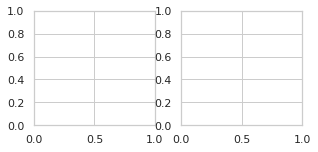

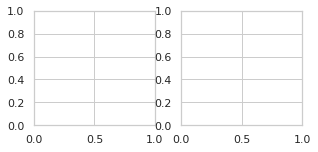

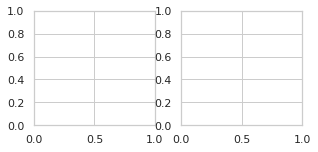

In [4]:
layout = fifi.svg_to_axes.FigureLayout('../../../../Figure/motionAnalysis.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

In [5]:
ax=layout.axes[('fig1','ax1')]

lw=0.5
msize=3

ax.plot(result['time'], result['r'], linewidth=lw,rasterized=True)
ax.set_xlabel('Time,s')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel('r')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)
ax.set_xlim(0,700)

ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4}, 
                            smart_bounds=True,
                            xticks=[0,700],
                            yticks = [0,60],
                            linewidth=0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [6]:
ax=layout.axes[('fig1','ax2')]

lw=0.5
msize=3

ax.plot(result['time'], result['theta'], linewidth=lw,rasterized=True)
ax.set_xlabel('200 secs')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel(r'$\Theta$')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)
ax.set_xlim(100,300)

ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[100,300],
                            yticks = [-3.5,3.5],
                            linewidth=0.5)
ax.set_xticklabels([])

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [7]:
ax=layout.axes[('fig2','ax3')]

lw=0.5
msize=3

ax.plot(frequencies, np.abs(r_dot_fft), linewidth=lw,rasterized=True)

ax.set_xlabel('Frequency (Hz)')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel('Amplitude of $\overset{\circ}{r}$')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)
ax.set_xlim(0,1)

ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,27000],
                            linewidth=0.5)
# ax.set_xticklabels([])

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [8]:
ax=layout.axes[('fig2','ax4')]

lw=0.5
msize=3

ax.plot(frequencies, np.abs(theta_dot_fft), linewidth=lw,rasterized=True)

ax.set_xlabel('Frequency (Hz)')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel('Amplitude of $\overset{\circ}{\Theta}$')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)
ax.set_xlim(0,1)

ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,5000],
                            linewidth=0.5)
# ax.set_xticklabels([])

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [9]:
ax=layout.axes[('fig3','ax5')]

lw=0.5
msize=3

sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax)

ax.set_xlabel('Distance Along\nStreakline, m')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel('Kernel Density Estimate')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)
# ax.set_xlim(0,1)

ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,60],
                            yticks = [0,0.08],
                            linewidth=0.5)
# ax.set_xticklabels([])

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig3'], 'fig3', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [10]:
ax=layout.axes[('fig3','ax6')]

lw=0.5
msize=3

ax.hist(df1.distance_from_source_a*df1.xsign, bins=50,rasterized=True)

ax.set_xlabel('Distance Along\nStreakline, m')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.set_ylabel('Count')
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.grid(False)


ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,60],
                            yticks = [0,45000],
                            linewidth=0.5)
# ax.set_xticklabels([])

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig3'], 'fig3', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')